# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model
## Context
Retinal Optical Coherence Tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

![Figure 1.](https://i.imgur.com/fSTeZMd.png)

Figure 1. Representative Optical Coherence Tomography Images and the Workflow Diagram \[Kermany et. al. 2018\]

(A) (Far left) Choroidal Neo-Vascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic Macular Edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

## Content
* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).
* Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

* Optical coherence tomography (OCT) images (Spectralis OCT, Heidelberg Engineering, Germany) were selected from retrospective cohorts of adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017.

## Acknowledgements
* Data: https://data.mendeley.com/datasets/rscbjbr9sj/2
* Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Installing and Importing Libraries

In [1]:
#!pip install keract

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

## Importing Dataset and Data Pre-Processing

In [3]:
data_dir = "../data/OCT2017/"
train_data_dir= '../data/OCT2017/train/'
val_data_dir= '../data/OCT2017/val/'
test_data_dir= '../data/OCT2017/test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32

In [4]:
cnv_images = len(glob(train_data_dir + 'CNV/*.jpeg'))
dme_images = len(glob(train_data_dir + 'DME/*.jpeg'))
drusen_images = len(glob(train_data_dir + 'DRUSEN/*.jpeg'))
normal_images = len(glob(train_data_dir + 'NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values())
print('cnv ', cnv_images, '\ndme ', dme_images,'\ndrusen ', drusen_images,'\nnormal ', normal_images)
print('total :', cnv_images+dme_images+drusen_images+normal_images)

cnv  37205 
dme  11348 
drusen  8616 
normal  26315
total : 83484


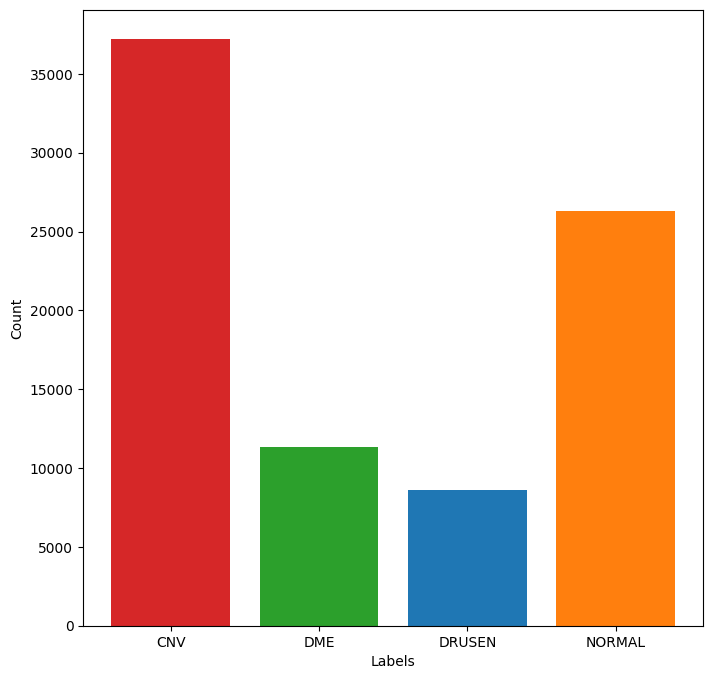

In [5]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('img/labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

### Image Histogram (Tonal Distribution)
* Histogram of a normal retina image in the train dataset:

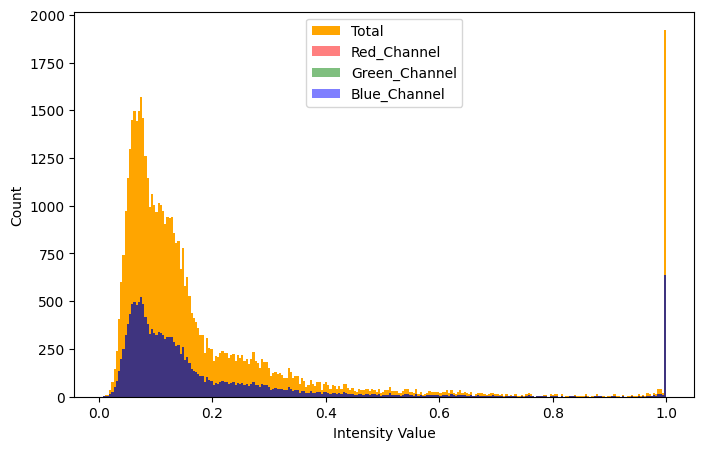

In [6]:
image = mpimg.imread(data_dir + 'train/NORMAL/NORMAL-1001666-1.jpeg')
color_img= gray2rgb(resize(image, (128, 128)))
plt.rcParams['figure.figsize'] = (8.0, 5.0)
_ = plt.hist(color_img.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(color_img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(color_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(color_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.savefig('img/histogram.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

### Sample Images from the Dataset

Normal


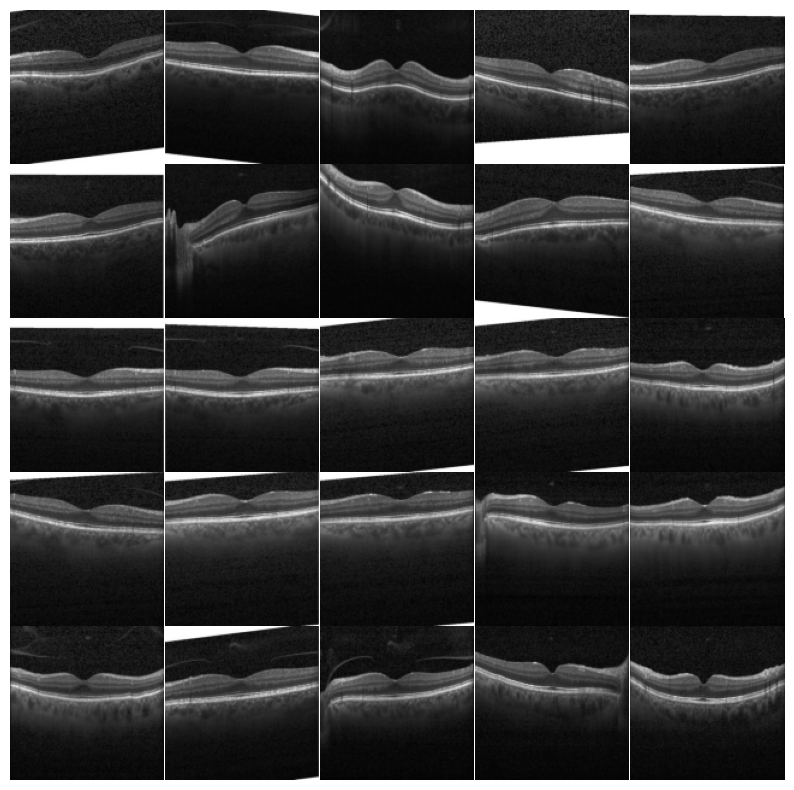

In [7]:
print("Normal")
multipleImages = glob(data_dir + 'train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('img/normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


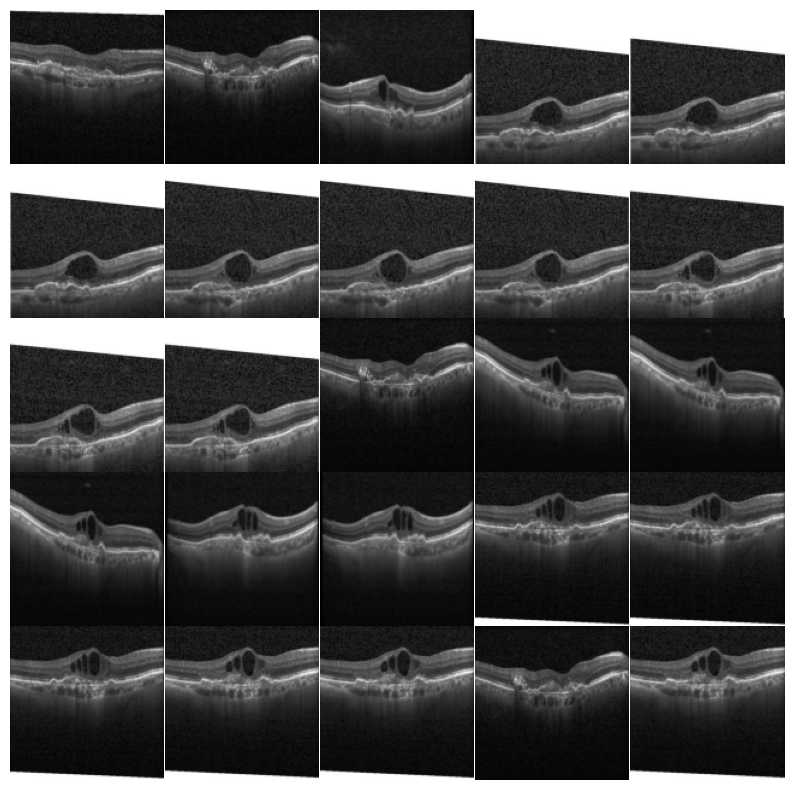

In [8]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + 'train/CNV/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('img/cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Diabetic Macular Edema (DME)


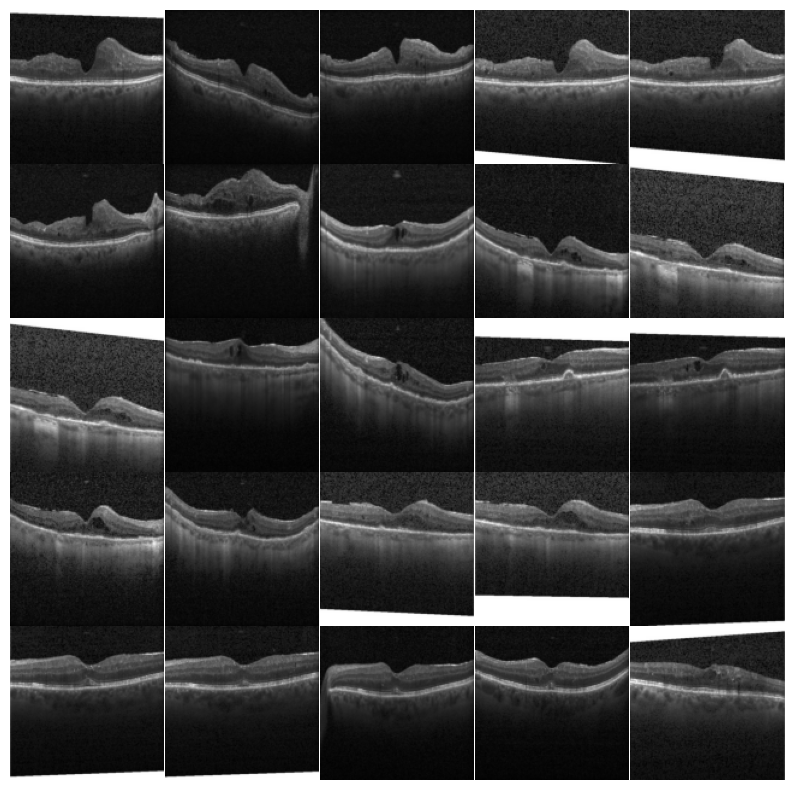

In [9]:
print("Diabetic Macular Edema (DME)") 
multipleImages = glob(data_dir + 'train/DME/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('img/dme_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Drusen


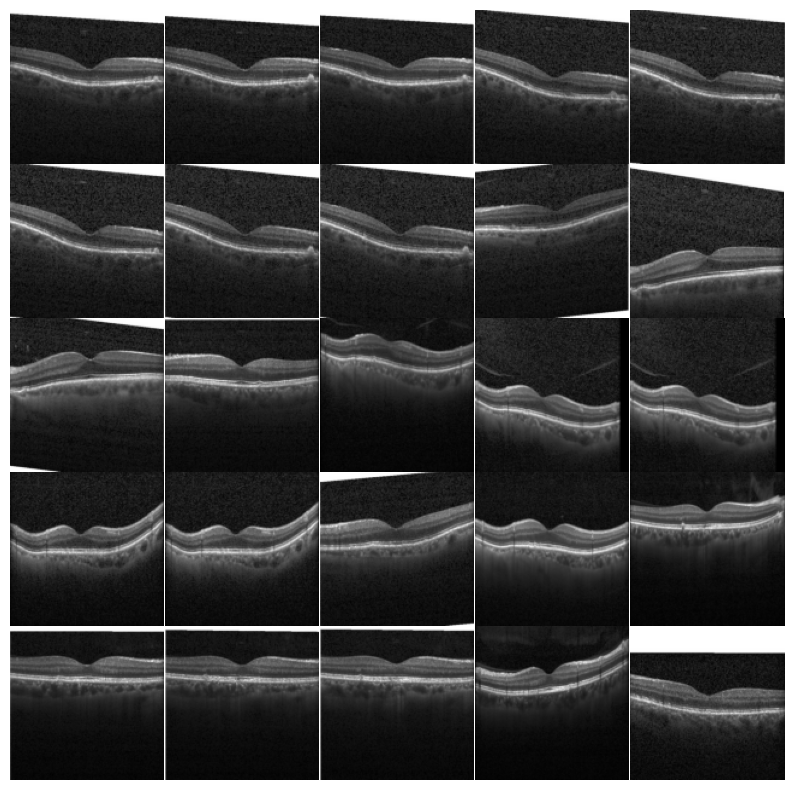

In [10]:
print("Drusen")
multipleImages = glob(data_dir + 'train/DRUSEN/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('img/drusen_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

### Keras Data Generators

In [11]:
# instanciation de generateurs de données d'entrainement et de test
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [12]:
# génération de jeux de données d'entrainement et de test
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

# %store test_generator

Found 83484 images belonging to 4 classes.
Found 0 images belonging to 0 classes.
Found 1000 images belonging to 4 classes.


In [13]:
# encodage des catégories
num_classes = len(train_generator.class_indices)  

train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

In [14]:
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

print('train set :', nb_train_samples,'\nvalidation set :', nb_valid_samples, '\ntest set :', nb_test_samples)

train set : 83484 
validation set : 0 
test set : 1000


# Model
* VGG16 CNN architecture is used for classification.
* Pretrained on the 'ImageNet' dataset.

In [15]:
# instanciation d'un model VGG16 avec pré-entrainement imagenet
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [16]:
# creation du model avec transfert learning de vgg16 et ajout de couches de sortie
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

## Baseline Model Training

In [26]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate= 0.0001), 
    loss='categorical_crossentropy', 
    metrics= ['accuracy']
    )

In [27]:
# définition des hyperparamètres du model
numepochs = 5
batch_size = 128
model_name='vgg16_e5b128'
checkpoint_filepath = model_name+'/tmp/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
callbacks_list = [earlystop,checkpoint]

In [28]:
# entrainement epoch 5 et batch 128
history = model.fit(train_generator, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        validation_data=valid_generator, 
                        verbose=1,
                        callbacks = callbacks_list
                        )


Epoch 1/5
   2/2609 [..............................] - ETA: 1:16:49 - loss: 1.2734 - accuracy: 0.4531

KeyboardInterrupt: 

Evaluations on Test Dataset

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 4s 129ms/step - loss: 0.3306 - accuracy: 0.8729
Test Loss:  0.3305940330028534
Test Accuracy:  0.8729338645935059


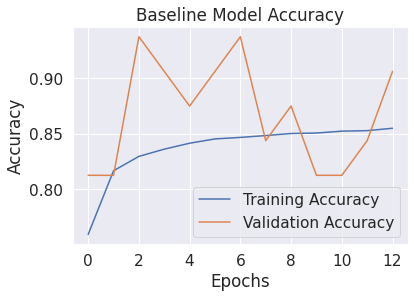

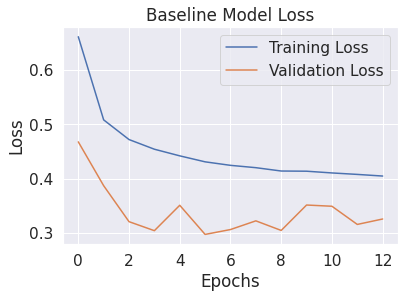

In [ ]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

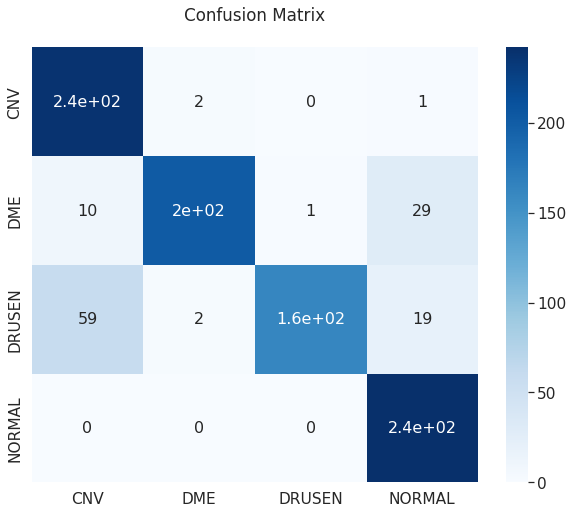

Classification Report

              precision    recall  f1-score   support

         CNV       0.78      0.99      0.87       242
         DME       0.98      0.83      0.90       242
      DRUSEN       0.99      0.67      0.80       242
      NORMAL       0.83      1.00      0.91       242

    accuracy                           0.87       968
   macro avg       0.90      0.87      0.87       968
weighted avg       0.90      0.87      0.87       968



In [ ]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix_'+model_name+'.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Save the model

In [ ]:
# save model and architecture to single file
model.save('retinal_oct_model_'+model_name+'.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('retinal_oct_model_'+model_name+'.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('retinal_oct_model_'+model_name+'_weights.h5')

In [ ]:
import json
# save model metrics
json_model_eval = {}
json_model_eval["model_name"]=model_name
json_model_eval["loss"] = eval_loss
json_model_eval["accuracy"] = eval_accuracy
with open('retinal_oct_model_'+model_name+'_eval.json', 'w') as json_file:
    json_file.write(str(json_model_eval))

In [29]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("retinal-oct.h5")

# Let's check:
# np.testing.assert_allclose(
#     model.predict(test_generator), 
#     reconstructed_model.predict(test_generator)
# )

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.fit(test_generator)


32/32 [==============================] - 83s 3s/step - loss: 0.2877 - accuracy: 0.9140


Prediction test

In [31]:

e5b128_model = keras.models.load_model("vE5-B128/retinal_oct_model_vE5-B128.h5")
e5b128_model.fit(test_generator)

32/32 [==============================] - 86s 3s/step - loss: 0.3278 - accuracy: 0.8960


In [32]:
e10b64_model = keras.models.load_model("vE10-B64/retinal_oct_model_vE10-B64.h5")
e10b64_model.fit(test_generator)

32/32 [==============================] - 82s 3s/step - loss: 0.3077 - accuracy: 0.8940


In [34]:
e20b32_model = keras.models.load_model("vE20-B32/retinal_oct_model_vE20-B32.h5")
e20b32_model.fit(test_generator)

32/32 [==============================] - 84s 3s/step - loss: 0.2852 - accuracy: 0.9130


In [ ]:
from PIL import Image
import io
model = tf.keras.models.load_model('retinal-oct-v10_500.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

test_image = keras.utils.load_img(test_data_dir+"/CNV/CNV-1016042-1.jpeg", target_size = (150, 150)) 
test_image = keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = np.argmax(model.predict(test_image))
print(result)
print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(result)])